In [206]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
import torch
import matplotlib.pyplot as plt


In [207]:
#Loading the training file
file_path = '/Users/diana/Desktop/isear-train.xlsx'
custom_headers = ['Emotions', 'Text']
df = pd.read_excel(file_path, skiprows=1, header=None, names=custom_headers)

In [208]:
label_encoding = {'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}
y = df['Emotions'].values
y_train_encoded = np.array([label_encoding[label] for label in y])
print("Encoded labels:", y, y_train_encoded[:20])

Encoded labels: ['sadness' 'disgust' 'fear' ... 'sadness' 'disgust' 'fear'] [5 1 2 6 0 6 1 4 6 4 1 0 0 4 2 4 6 2 1 5]


In [4]:
#conda install torch transformers openpyxl


In [5]:
pip  install torch

Note: you may need to restart the kernel to use updated packages.


In [209]:
print (type(df['Text']))
strings = []
for index, sentence in enumerate(df['Text']):
    emotion_label = df['Emotions'][index]
    strings.append (sentence)
#print (strings[0:3])

<class 'pandas.core.series.Series'>


In [210]:
#Creating BERT embeddings for the TRAINSET
bert_model = RobertaModel.from_pretrained('roberta-base', output_hidden_states=True)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#model = BertModel.from_pretrained('bert-base-uncased').to(device)

def get_sentence_embeddings(text_list, batch_size=32):
    all_embeddings = []

    # Process each sublist separately
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i + batch_size]
        #print(f"Processing batch from index {i} to {i + len(batch)}")
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
        
        with torch.no_grad():
            outputs = bert_model(**inputs)

        # Extract the hidden state of the CLS token (first token)
        cls_embeddings = outputs.hidden_states[-1][:, 0, :]  # the last layer's CLS token state
        all_embeddings.append(cls_embeddings)  

    # Concatenate all batch embeddings
    sentence_embeddings = torch.cat(all_embeddings, dim=0)
    
    return sentence_embeddings

# Example usage with strings_dev
# sentence_embeddings_dev = get_sentence_embeddings(strings_dev)
# print("Sentence embeddings shape:", sentence_embeddings_dev.shape)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [211]:
#sentence_embeddings = '/Users/diana/Desktop/TL/sentence_embeddings.pt'
#sentence_embeddings = torch.load(sentence_embeddings)
sentence_embeddings = get_sentence_embeddings(strings)



In [92]:
sentence_embeddings_roberta = '/Users/diana/Desktop/TL/ROBERTA_sentence_embeddings.pt'


In [93]:
print (sentence_embeddings.shape)

torch.Size([5366, 768])


In [213]:
#Devset BERT
file_path_dev = '/Users/diana/Desktop/isear-validation.xlsx'
custom_headers_dev = ['Emotions_dev', 'Text_dev']
df = pd.read_excel(file_path_dev, skiprows=1, header=None, names=custom_headers_dev)

print (type(df['Text_dev']))
strings_dev = []
for index, sentence in enumerate(df['Text_dev']):
    emotion_label_dev = df['Emotions_dev'][index]
    strings_dev.append (sentence)
#print (strings_dev[0:3])


y_dev = df['Emotions_dev'].values
y_dev_encoded = np.array([label_encoding[label] for label in y_dev])
y_dev_tensor = torch.tensor (y_dev_encoded)
#print (len (strings_dev))
#print (y_dev_tensor.shape)


<class 'pandas.core.series.Series'>


In [214]:
#Testset BERT
file_path_test = '/Users/diana/Desktop/isear-test.xlsx'
custom_headers_test = ['Emotions_test', 'Text_test']
df = pd.read_excel(file_path_test, skiprows=1, header=None, names=custom_headers_test)

strings_test = []
for index, sentence in enumerate(df['Text_test']):
    emotion_label_test = df['Emotions_test'][index]


strings_test = df['Text_test'].tolist()
#print (strings_test)

y_test = df['Emotions_test'].values
y_test_encoded = np.array([label_encoding[label] for label in y_test])
y_test_encoded = torch.tensor (y_test_encoded)
print (len (df['Text_test']))



1150


In [215]:
#devset embeddings
sentence_embeddings_dev = get_sentence_embeddings(strings_dev)
# Print the shape of the embeddings
print("Sentence embeddings shape:", sentence_embeddings_dev.shape)

Sentence embeddings shape: torch.Size([1150, 768])


In [216]:
#testset
sentence_embeddings_test = get_sentence_embeddings(strings_test)
print("Sentence embeddings shape:", sentence_embeddings_test.shape)

Sentence embeddings shape: torch.Size([1150, 768])


In [217]:
torch.save(sentence_embeddings, "sentence_embeddings.pt")
# To load the embeddings later
loaded_embeddings = torch.load("sentence_embeddings.pt")

In [218]:
print (type (sentence_embeddings))
y_train_tensor = torch.tensor(y_train_encoded)
y_test_tensor = torch.tensor(y_test_encoded)
print (y_dev_tensor.shape, y_test_tensor.shape,y_train_tensor.shape ) 

<class 'torch.Tensor'>
torch.Size([1150]) torch.Size([1150]) torch.Size([5366])


/var/folders/mh/2g8pjxqx2dldlw8dltkfmgvm0000gn/T/ipykernel_36481/1177048907.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(y_test_encoded)


In [318]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
embeddings = torch.tensor(sentence_embeddings, dtype=torch.float32).to(device)
labels = torch.tensor(y_train_tensor, dtype=torch.long).to(device)

embeddings_dev = torch.tensor(sentence_embeddings_dev, dtype=torch.float32)
labels_dev = torch.tensor(y_dev_encoded, dtype=torch.long)

embeddings_test = torch.tensor(sentence_embeddings_test, dtype=torch.float32)
labels_test = torch.tensor(y_test_tensor, dtype=torch.long)

# Create a dataset and dataloader
dataset = TensorDataset(embeddings, labels)
dataset_dev = TensorDataset(embeddings_dev,labels_dev)
dataset_test = TensorDataset(embeddings_test,labels_test)


train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_dev, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)


class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.relu1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.relu2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
input_dim = 768  # Dimension of BERT embeddings
hidden_dim1 = 32
hidden_dim2 = 32
output_dim = 7  # Number of emotion classes

/var/folders/mh/2g8pjxqx2dldlw8dltkfmgvm0000gn/T/ipykernel_36481/3202324245.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings = torch.tensor(sentence_embeddings, dtype=torch.float32).to(device)
/var/folders/mh/2g8pjxqx2dldlw8dltkfmgvm0000gn/T/ipykernel_36481/3202324245.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(y_train_tensor, dtype=torch.long).to(device)
/var/folders/mh/2g8pjxqx2dldlw8dltkfmgvm0000gn/T/ipykernel_36481/3202324245.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embeddings_dev

In [339]:
simp_model = SimpleNN(input_dim, hidden_dim1, output_dim).to(device)
lossf = nn.CrossEntropyLoss()
optimizer = optim.AdamW(simp_model.parameters(), lr=0.001, weight_decay=1e-6) # L2 regularization #

In [344]:
num_epochs = 150

# Initialize lists to store losses
train_losses = []
val_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training phase
    simp_model.train()
    train_loss = 0.0
    
    for batch_embeddings, batch_labels in train_loader:
        # Forward pass
        outputs = simp_model(batch_embeddings)
        loss = lossf(outputs, batch_labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Calculate average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    simp_model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for batch_embeddings, batch_labels in val_loader:
            outputs = simp_model(batch_embeddings)
            loss = lossf(outputs, batch_labels)
            val_loss += loss.item()
    
    # Calculate average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Test phase
    simp_model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for batch_embeddings, batch_labels in test_loader:
            outputs = simp_model(batch_embeddings)
            loss = lossf(outputs, batch_labels)
            test_loss += loss.item()
    
    # Calculate average test loss
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    #print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

In [343]:
from sklearn.metrics import f1_score

simp_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for batch_embeddings, batch_labels in test_loader:
        outputs = simp_model(batch_embeddings)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
    f1 = f1_score(predicted , batch_labels, average='weighted')
    f1_macro = f1_score(predicted , batch_labels, average='macro')
    print (f1, f1_macro)
    print(f'Accuracy of the model on the data: {100 * correct / total:.2f}%')

0.6957575757575756 0.5840445269016696
Accuracy of the model on the data: 62.00%


ValueError: x and y must have same first dimension, but have shapes (200,) and (0,)

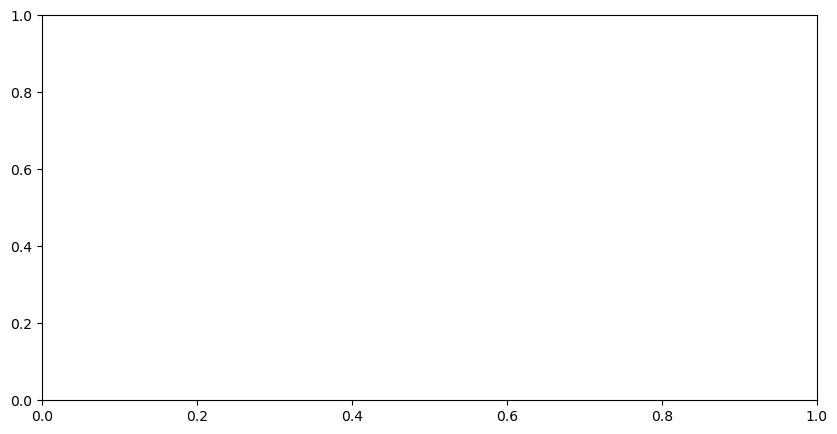

In [332]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss over Epochs')
plt.legend()
plt.show()


In [ ]:
pip install shap

In [201]:
"""import shap

dataiter = iter(test_loader)
test_data, test_labels = dataiter.next()

background_data = embeddings[:100]  # 100 instances from the training set

explainer = shap.DeepExplainer(simp_model, background_data)

# Generate SHAP values
test_data.requires_grad = True
shap_values = explainer.shap_values(test_data)"""

'import shap\n\ndataiter = iter(test_loader)\ntest_data, test_labels = dataiter.next()\n\nbackground_data = embeddings[:100]  # 100 instances from the training set\n\nexplainer = shap.DeepExplainer(simp_model, background_data)\n\n# Generate SHAP values\ntest_data.requires_grad = True\nshap_values = explainer.shap_values(test_data)'